#A NEURAL NETWORK MACHINE LEARNING MODEL TO PREDICT A COMPANY'S STOCK PRICE

this project is completed by myself alone for the purpose of practicing Python and machine learning skills, and improve machine learning knowledges. This project contain 

# PART 1: DATA PREPROCESSING

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader



> **import dataset**



In [ ]:
url = 'https://raw.githubusercontent.com/williamLIZIHAO/stock_prediction/main/GOOGL.csv'
df = pd.read_csv(url)



> **select only the closing price**



In [ ]:
df1 = df.reset_index()['Close']

> ploting the closing value of Google stock



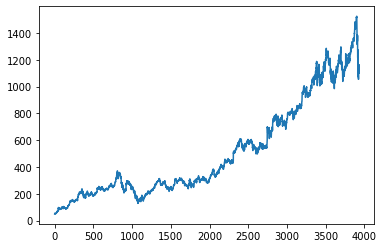

In [ ]:
plt.plot(df1)

In [ ]:
df1

0         50.220219
1         54.209209
2         54.754753
3         52.487488
4         53.053055
           ...     
3927    1162.920044
3928    1110.260010
3929    1146.310059
3930    1161.949951
3931    1102.099976
Name: Close, Length: 3932, dtype: float64

#PART 2: BUILDING MACHINE LEARNING MODEL

## PART 2.1 DATA PREPARATION



> using MinMaxScaler to transform all data points


> also transformed the dataset to an array with shape of one column and length of the dataset rows





In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
df1 = np.array(df1).reshape(-1, 1)
df1 = sc.fit_transform(df1)
df1

array([[1.11990286e-04],
       [2.81673016e-03],
       [3.18663669e-03],
       ...,
       [7.43316991e-01],
       [7.53921639e-01],
       [7.13340293e-01]])



> seperate independent and dependent data. to do so, I created a user defined function where I can append a sequnece of data points to X an Y that show below:
*   X: [[1: 100], [2:101], [3:102], .... ,[n - 101, n - 1]]
*   Y: [101, 102, 103, ..... , n]








In [ ]:
def processData(data, lookback):
  x, y = [], []
  for i in range(len(data) - lookback - 1):
    x.append(data[i: (i+lookback), 0])
    y.append(data[(i+ lookback), 0])
  return np.array(x),  np.array(y)


x, y = processData(df1, 100)
x

array([[1.11990286e-04, 2.81673016e-03, 3.18663669e-03, ...,
        3.00473738e-02, 3.18460055e-02, 3.22566374e-02],
       [2.81673016e-03, 3.18663669e-03, 1.64931478e-03, ...,
        3.18460055e-02, 3.22566374e-02, 3.17408049e-02],
       [3.18663669e-03, 1.64931478e-03, 2.03279816e-03, ...,
        3.22566374e-02, 3.17408049e-02, 3.23652367e-02],
       ...,
       [8.28710716e-01, 8.40481675e-01, 8.41722478e-01, ...,
        7.32264724e-01, 7.13014841e-01, 7.54579411e-01],
       [8.40481675e-01, 8.41722478e-01, 8.41430963e-01, ...,
        7.13014841e-01, 7.54579411e-01, 7.18873213e-01],
       [8.41722478e-01, 8.41430963e-01, 8.52232272e-01, ...,
        7.54579411e-01, 7.18873213e-01, 7.43316991e-01]])



> 





> here I made train & test split. 80% will be used to train and 20% will be used to test



In [ ]:
x_train, x_test = x[:int(x.shape[0]*0.80)], x[int(x.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)], y[int(y.shape[0]*0.80):]

print(x_train.shape[0])
print(x_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

3064
767
3064
767


## PART 2.2 RECURRENT NEURAL NETWORK MODEL

type of artificial neural network designed to work with sequential data, where the order of the input matters. The key feature of RNNs is that they have hidden states that capture the context and dependencies of the previous inputs.The basic architecture of an RNN includes an input layer, a hidden layer, and an output layer. 

For my RNN model, I have created two layers: 


*   LSTM Layer
*   Linear Layer



In [ ]:
class RNN(nn.Module):
  def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional = True):
    super(RNN, self).__init__()
    self.num_directions = bidirectional+1
    self.rnn = nn.LSTM(
        input_size=i_size,
        hidden_size=h_size,
        num_layers = n_layers,
        dropout = dropout,
        bidirectional = bidirectional
    )
    self.out = nn.Linear(h_size, o_size)

  def forward(self, x, h_state):
    r_out, hidden_state = self.rnn(x, h_state)

    hidden_size=  hidden_state[-1].size(-1)
    r_out = r_out.view(-1, self.num_directions, hidden_size)
    outs = self.out(r_out)

    return outs, hidden_state

In [ ]:
input_size = 100
hidden_size = 64
num_layers = 3
output_size = 1
batch_size = 128

learning_rate = 0.001
num_epochs = 500

rnn = RNN(input_size, hidden_size, num_layers, output_size, bidirectional =False)
rnn.cuda()

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss() 

hidden_state = None



> reshaping the train and test array into this format 
*   (x_train.shape[0], 1, x_train.shape[1])

> convert it into tensor, which is required for dataset before putting into RNN model







In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [ ]:
history = []
x_test_cuda = torch.tensor(x_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

inputs_cuda = torch.tensor(x_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()



> model trainning and optimization process.


> for every 20 iteration, checking on the loss of test dataset between predict and actual ys' . otherwise only show trainset's loss





In [ ]:
for epoch in range(num_epochs):
  rnn.train()
  output, _ = rnn(inputs_cuda, hidden_state)
  print(output.size())

  loss = criterion(output[:,0,:].view(-1), labels_cuda)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 20 == 0:
    rnn.eval()
    test_output, _ = rnn(x_test_cuda, hidden_state)
    test_loss = criterion(test_output.view(-1), y_test_cuda)
    print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
  else:
    print('epoch {}, loss {}'.format(epoch, loss.item()))
  
  history.append(loss.item())
  

torch.Size([3064, 1, 1])
epoch 0, loss 0.04775448143482208, eval loss 0.39699167013168335
torch.Size([3064, 1, 1])
epoch 1, loss 0.03503188490867615
torch.Size([3064, 1, 1])
epoch 2, loss 0.02410503290593624
torch.Size([3064, 1, 1])
epoch 3, loss 0.015205415897071362
torch.Size([3064, 1, 1])
epoch 4, loss 0.009609411470592022
torch.Size([3064, 1, 1])
epoch 5, loss 0.00938123557716608
torch.Size([3064, 1, 1])
epoch 6, loss 0.01406329870223999
torch.Size([3064, 1, 1])
epoch 7, loss 0.015035013668239117
torch.Size([3064, 1, 1])
epoch 8, loss 0.012231466360390186
torch.Size([3064, 1, 1])
epoch 9, loss 0.008888558484613895
torch.Size([3064, 1, 1])
epoch 10, loss 0.007014124188572168
torch.Size([3064, 1, 1])
epoch 11, loss 0.006456517614424229
torch.Size([3064, 1, 1])
epoch 12, loss 0.00662322947755456
torch.Size([3064, 1, 1])
epoch 13, loss 0.006744261831045151
torch.Size([3064, 1, 1])
epoch 14, loss 0.0063756247982382774
torch.Size([3064, 1, 1])
epoch 15, loss 0.005306563805788755
torch.Si

In [ ]:
rnn.out.weight

Parameter containing:
tensor([[-0.0271,  0.0887,  0.0953, -0.0984,  0.1206,  0.1019, -0.1040, -0.1242,
          0.1001,  0.0959,  0.1147, -0.1016,  0.0582,  0.1116,  0.0299,  0.0046,
         -0.0286, -0.0183,  0.1146, -0.0121,  0.0501,  0.0629,  0.1035, -0.0309,
         -0.0095,  0.1271,  0.1001,  0.0526,  0.1173, -0.0748, -0.1023,  0.0502,
         -0.1022,  0.0588,  0.0898, -0.0594,  0.0962,  0.0126, -0.0586,  0.0419,
          0.0368,  0.0786,  0.0525, -0.0892,  0.0313, -0.1002,  0.0749, -0.1185,
          0.1204, -0.0462, -0.0578, -0.0781, -0.0874,  0.0271, -0.0453, -0.0622,
          0.0011, -0.0081,  0.1185,  0.0064,  0.0776,  0.0775,  0.0529, -0.0646]],
       device='cuda:0', requires_grad=True)

# Part 3: MODEL PERFORMANCE EVAL



> a plot of loss function overtime, to see the difference between prediction result and actual result

I am quite suprised by the fact that errors between actual and predicted are so low



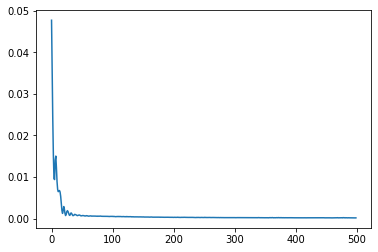

In [ ]:
plt.plot(history)

In [ ]:
rnn.eval()
test_predict, _ = rnn(x_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [ ]:
test_predict_cpu.shape

(767, 1, 1)

> showing a comparsion between predicted result and actual result

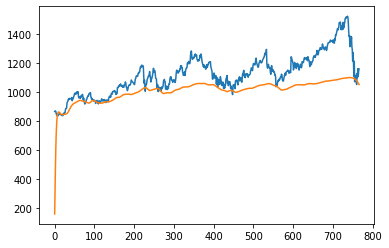

In [ ]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))

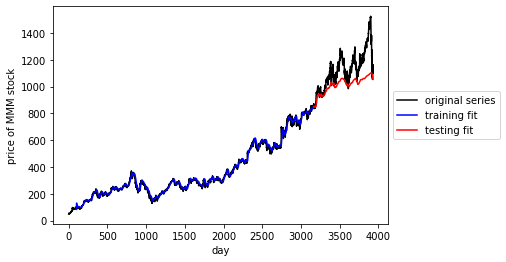

In [ ]:
# plot original data
plt.plot(sc.inverse_transform(df1.reshape(-1,1)), color='k')

train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(x_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

split_pt = int(x.shape[0] * 0.80) + 100 # window_size
plt.plot(np.arange(100, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

> from the graph can clearly see that from RNN model can only provide a very **rough prediction** of the direction where the price will lead to, *since uptrend price has conteracted with downtrend price. this is also the main reason that prediction is so rough but the MSE is so low.*




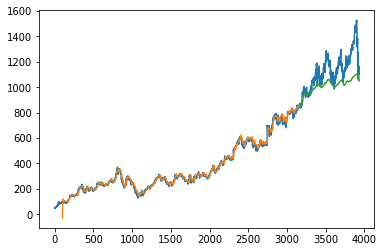

In [ ]:
'''
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(x_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

train_pred_cpu=sc.inverse_transform(train_pred_cpu.reshape(-1,1))
test_predict_cpu=sc.inverse_transform(test_predict_cpu.reshape(-1,1))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_pred_cpu)+look_back, :] = train_pred_cpu
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_pred_cpu)+look_back+1:len(df1), :] = test_predict_cpu
# plot baseline and predictions
plt.plot(sc.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
'''
